In [1]:
import matplotlib
matplotlib.use('Agg')

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import h5py
import collections
from functools import partial
from aesthetics.plotting import adjust_spines
from tqdm import tqdm
from scipy.stats import multivariate_normal
from scipy.signal import convolve2d

# imports from tensorflow/models/tutorial/image/imagenet/classify_image.py
import argparse
import os.path
import re
import sys
import tarfile
from six.moves import urllib

# from deepdream notebook http://nbviewer.jupyter.org/github/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/deepdream/deepdream.ipynb
from IPython.display import clear_output, Image, display, HTML

%matplotlib inline

plt.style.use('deepretina')

## Load VGG weights

In [2]:
# From https://www.cs.toronto.edu/~frossard/post/vgg16/
weight_file = os.path.expanduser('~/data/vgg16-model/vgg16_weights.npz')
weights = np.load(weight_file)
weight_keys = sorted(weights.keys())

In [3]:
weight_keys

['conv1_1_W',
 'conv1_1_b',
 'conv1_2_W',
 'conv1_2_b',
 'conv2_1_W',
 'conv2_1_b',
 'conv2_2_W',
 'conv2_2_b',
 'conv3_1_W',
 'conv3_1_b',
 'conv3_2_W',
 'conv3_2_b',
 'conv3_3_W',
 'conv3_3_b',
 'conv4_1_W',
 'conv4_1_b',
 'conv4_2_W',
 'conv4_2_b',
 'conv4_3_W',
 'conv4_3_b',
 'conv5_1_W',
 'conv5_1_b',
 'conv5_2_W',
 'conv5_2_b',
 'conv5_3_W',
 'conv5_3_b',
 'fc6_W',
 'fc6_b',
 'fc7_W',
 'fc7_b',
 'fc8_W',
 'fc8_b']

In [95]:
len(weight_keys)

32

In [4]:
weights[weight_keys[0]].shape

(3, 3, 3, 64)

## Create model from input variable X

In [7]:
single_unit_activation_maps = collections.defaultdict(list)

### Conv2_1 (Layer 5 or something in old keras/caffe VGG model architecture)

In [8]:
tf.reset_default_graph()
max_depth = 4 # must be less than 30 where FC layers start
height, width = (30,30)
with tf.variable_scope('input'):
    # Given an input tensor of shape `[batch, in_height, in_width, in_channels]`
    X = tf.get_variable("X", shape=(1,height,width,3), dtype=tf.float32, initializer=tf.random_normal_initializer(mean=0., stddev=10.))
    X_clipped = tf.clip_by_value(X, -128., 128.)

model = []
prev_output = X_clipped
# filter shape `[filter_height, filter_width, in_channels, out_channels]`
top_layer_reached = 'layer_1'
    
for i,layer in enumerate(weight_keys):
    if (layer[:4] == 'conv') and (layer[-1] == 'W') and (i <= max_depth):
        this_W = weights[layer]
        act_W = tf.nn.conv2d(prev_output, this_W, strides=[1,1,1,1], padding='SAME', use_cudnn_on_gpu=True)
        prev_output = tf.nn.relu(act_W + weights[weight_keys[i+1]])
        model.append(prev_output)
        
        top_layer_reached = layer

num_units = this_W.shape[-1]
my_choices = np.random.choice(range(num_units), size=64, replace=False)
for i in tqdm(my_choices):
    selected_unit = i
    l2_reg = 1e-1
    desirable_activity = -tf.nn.l2_loss(model[-1][0,12:18,12:18,selected_unit])
    undesirable_activity = -l2_reg * tf.nn.l2_loss(X)

    lr = tf.placeholder(tf.float32, shape=[])
    opt = tf.train.AdamOptimizer(learning_rate=lr, beta1=0.99, beta2=0.99, epsilon=1e-08)
    grads = opt.compute_gradients(desirable_activity - undesirable_activity)
    train_op = opt.apply_gradients(grads)
    
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())

    iterations = 1000
    this_lr = 10.

    for it in range(iterations):
        g = sess.run([train_op], feed_dict={lr: this_lr})
        
        if it % 500 == 0:
            this_lr *= 0.1
            
    maximal_image = sess.run(X)
    # rescale to be in [0,1]
    rescaled_img = (maximal_image[0,:,:,:] - np.min(maximal_image[0,:,:,:]))
    rescaled_img /= np.max(rescaled_img)
    single_unit_activation_maps[top_layer_reached].append(rescaled_img)

100%|██████████| 64/64 [03:27<00:00,  3.42s/it]


In [9]:
top_layer_reached

'conv2_1_W'

(-0.5, 248.5, 248.5, -0.5)

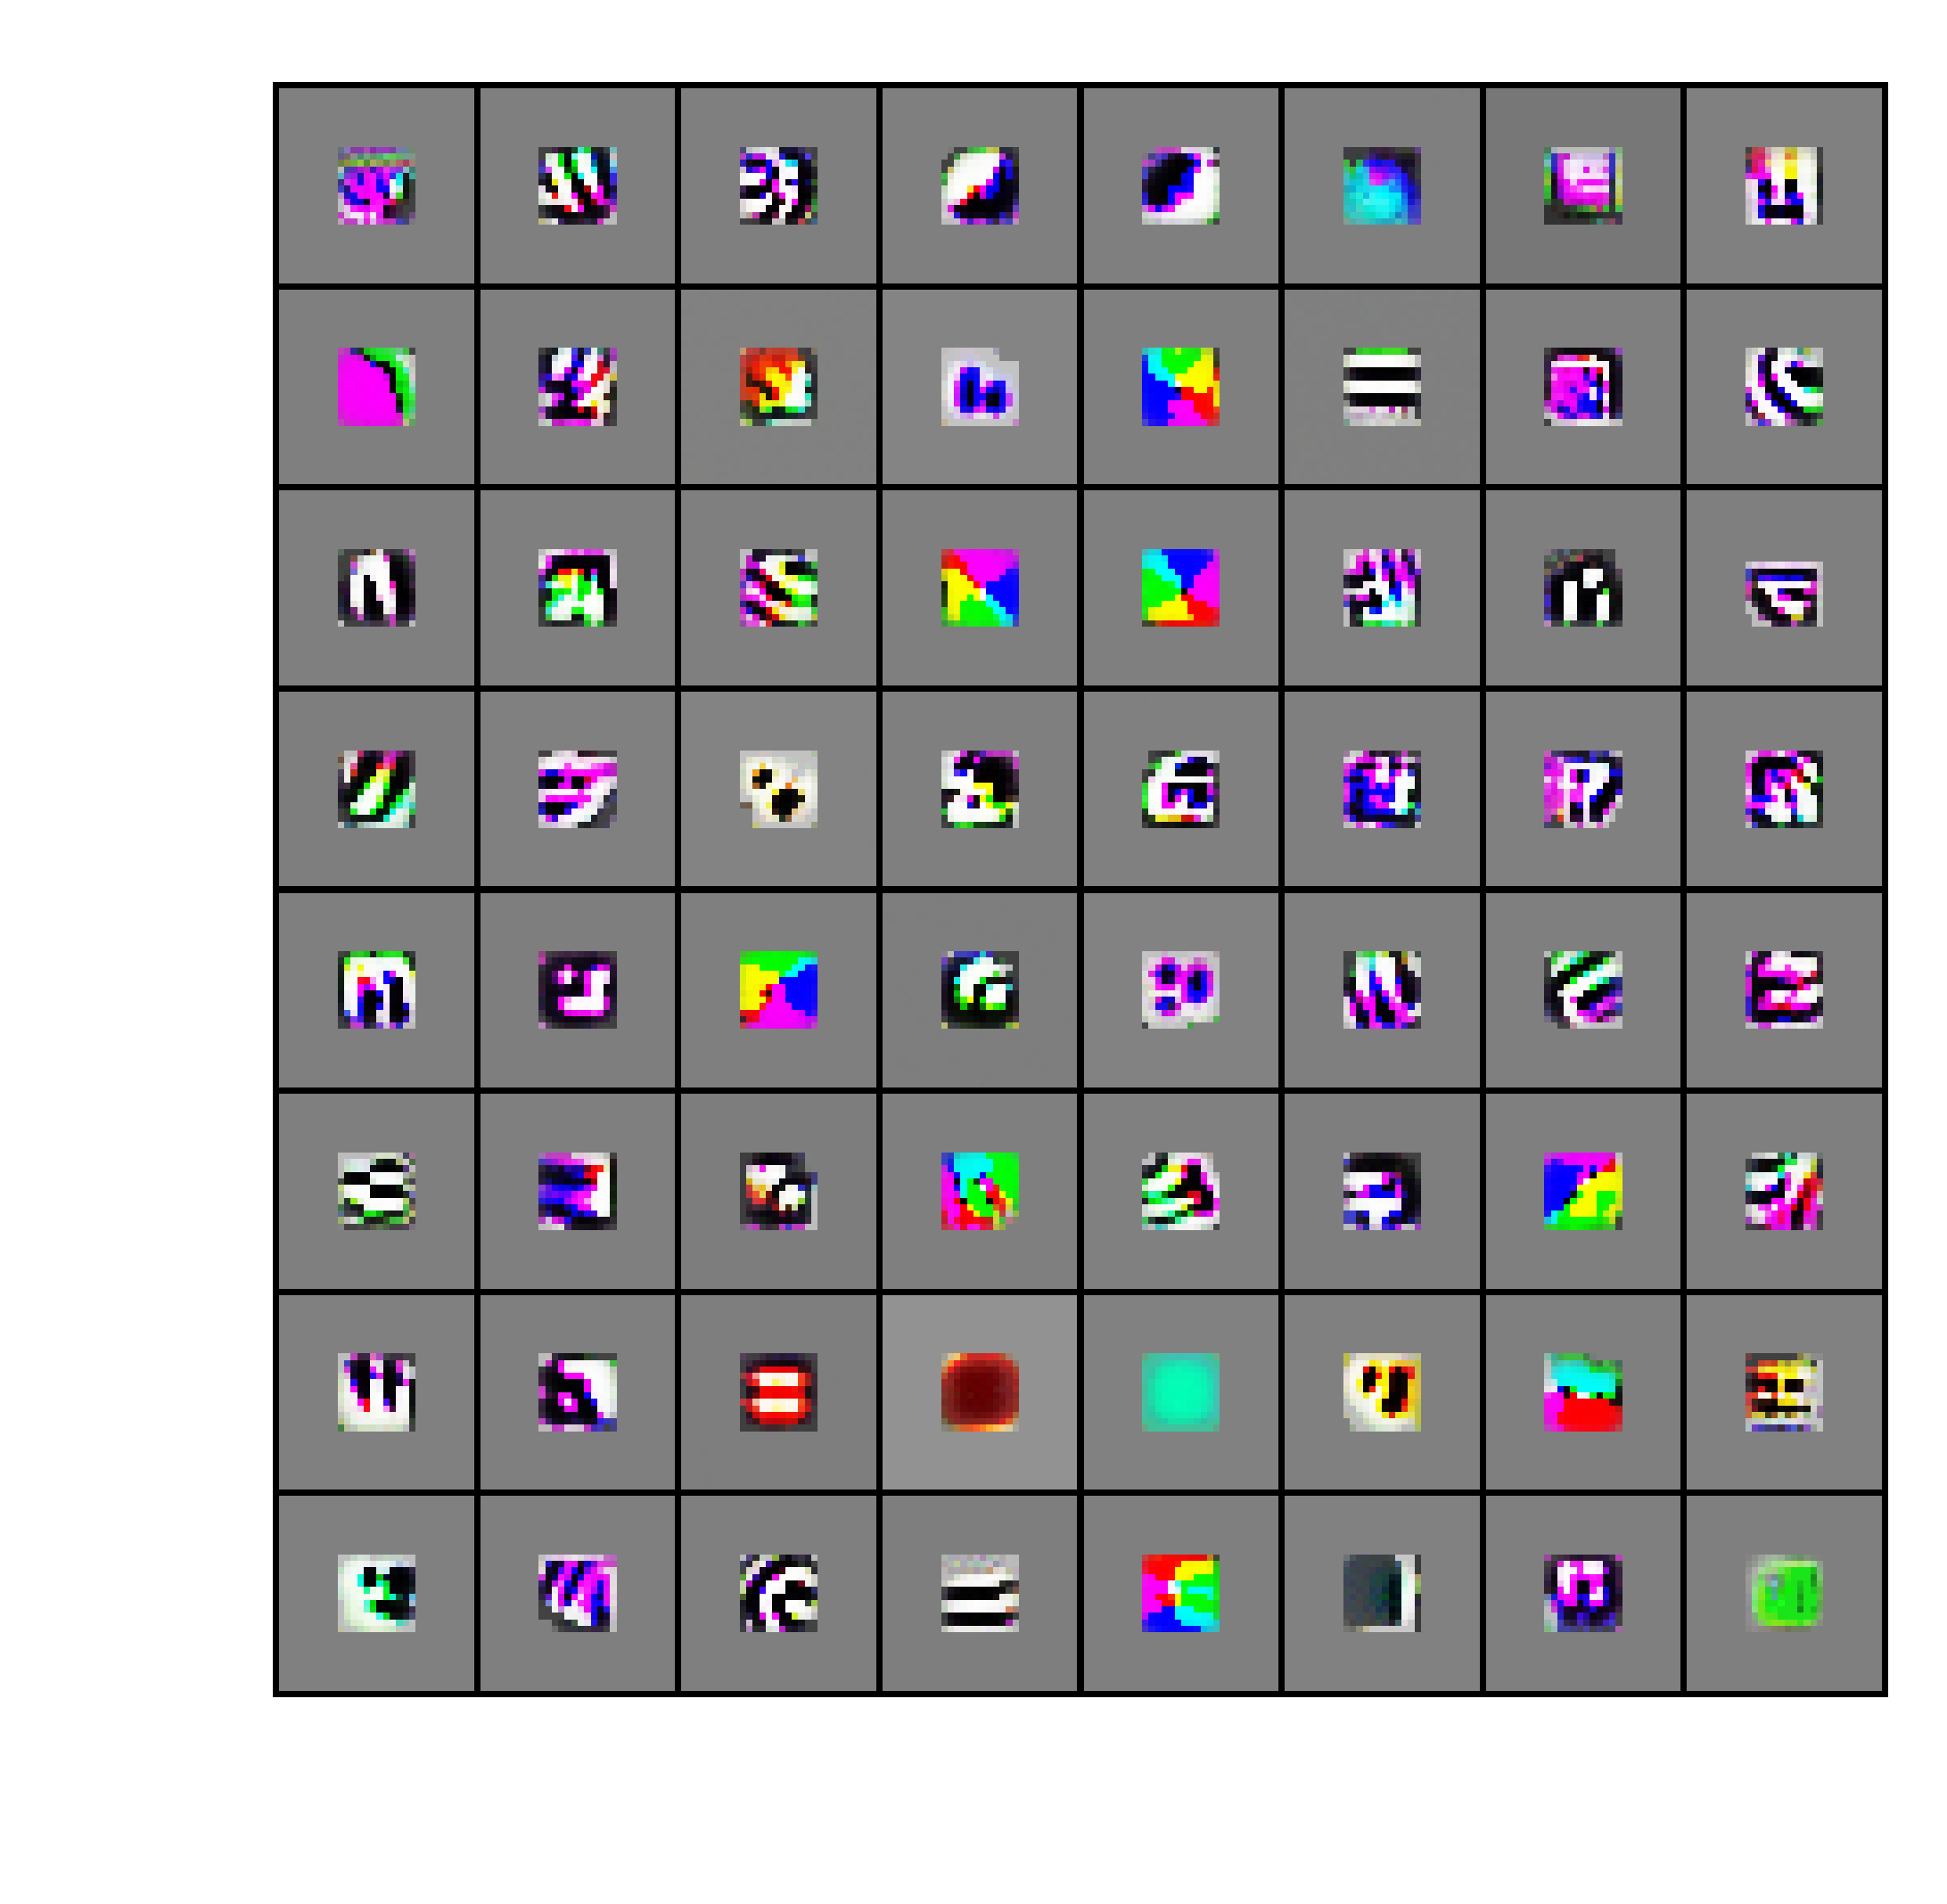

In [10]:
display_map = np.zeros(((height+1)*8 + 1, (width+1)*8 + 1, 3)) # black with one pixel in between each map
for idm,m in enumerate(single_unit_activation_maps['conv2_1_W'][-64:]):
    ycoord = int(idm/8.0)
    xcoord = idm % 8
    display_map[(1+ycoord*(height+1)):((ycoord+1)*(height+1)), (1+(xcoord)*(width+1)):((xcoord+1)*(width+1))] = m #[:,:,[2,1,0]]
    
plt.imshow(display_map)
plt.axis('off')

### Now do the same thing but initialize input to be an actual image

In [40]:
im = np.array(matplotlib.image.imread(os.path.expanduser('~/data/images/my_images/cropped/cat_sophie.jpg')))

In [41]:
im.shape

(100, 100, 3)

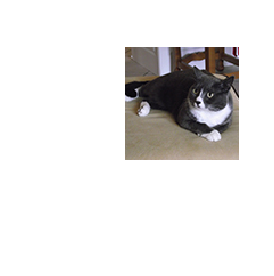

In [42]:
%config InlineBackend.print_figure_kwargs={'bbox_inches':None}
fig = plt.figure(figsize=(0.5,0.5), frameon=False, dpi=300)
plt.imshow(im)
_ = plt.axis('off')

#### Preprocess im for input to VGG network

In [66]:
(im.min(), im.max())

(0, 255)

In [85]:
im = PIL.Image.open(os.path.expanduser('~/data/images/my_images/cropped/cat_sophie.jpg'))
initial_im = PIL.Image.Image.resize(im, (30,30), resample=PIL.Image.LANCZOS)

In [86]:
initial_im = np.array(initial_im).astype('float32')
# initial_im = np.expand_dims(initial_im, 0)
initial_im -= np.mean(initial_im)
initial_im *= 0.7
(initial_im.min(), initial_im.max())

(-71.605331, 106.89466)

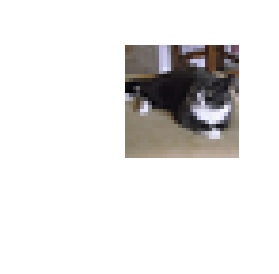

In [87]:
fig = plt.figure(figsize=(0.5,0.5), frameon=False, dpi=300)
plt.imshow((initial_im-initial_im.min())/(initial_im.max()-initial_im.min()))
_ = plt.axis('off')

In [88]:
initial_im = np.expand_dims(initial_im, 0)
initial_im.shape

(1, 30, 30, 3)

#### Run the network again, but now using initial image

In [89]:
image_activation_maps = collections.defaultdict(list)

In [90]:
tf.reset_default_graph()
max_depth = 4 # must be less than 30 where FC layers start
# height, width = (100,100)
height, width = (initial_im.shape[1], initial_im.shape[2])
with tf.variable_scope('input'):
    # Given an input tensor of shape `[batch, in_height, in_width, in_channels]`
    X = tf.get_variable("X", dtype=tf.float32, initializer=tf.constant(initial_im))
    X_clipped = tf.clip_by_value(X, -128., 128.)

model = []
prev_output = X_clipped
# filter shape `[filter_height, filter_width, in_channels, out_channels]`
top_layer_reached = 'layer_1'
    
for i,layer in enumerate(weight_keys):
    if (layer[:4] == 'conv') and (layer[-1] == 'W') and (i <= max_depth):
        this_W = weights[layer]
        act_W = tf.nn.conv2d(prev_output, this_W, strides=[1,1,1,1], padding='SAME', use_cudnn_on_gpu=True)
        prev_output = tf.nn.relu(act_W + weights[weight_keys[i+1]])
        model.append(prev_output)
        
        top_layer_reached = layer

num_units = this_W.shape[-1]
my_choices = np.random.choice(range(num_units), size=64, replace=False)
for i in tqdm(my_choices):
    selected_unit = i
    l2_reg = 1e-1
    desirable_activity = -tf.nn.l2_loss(model[-1][0,12:18,12:18,selected_unit])
    undesirable_activity = -l2_reg * tf.nn.l2_loss(X)

    lr = tf.placeholder(tf.float32, shape=[])
    opt = tf.train.AdamOptimizer(learning_rate=lr, beta1=0.99, beta2=0.99, epsilon=1e-08)
    grads = opt.compute_gradients(desirable_activity - undesirable_activity)
    train_op = opt.apply_gradients(grads)
    
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())

    iterations = 1000
    this_lr = 10.

    for it in range(iterations):
        g = sess.run([train_op], feed_dict={lr: this_lr})
        
        if it % 500 == 0:
            this_lr *= 0.1
            
    maximal_image = sess.run(X)
    # rescale to be in [0,1]
    rescaled_img = (maximal_image[0,:,:,:] - np.min(maximal_image[0,:,:,:]))
    rescaled_img /= np.max(rescaled_img)
    image_activation_maps[top_layer_reached].append(rescaled_img)

100%|██████████| 64/64 [03:24<00:00,  3.44s/it]


(-0.5, 248.5, 248.5, -0.5)

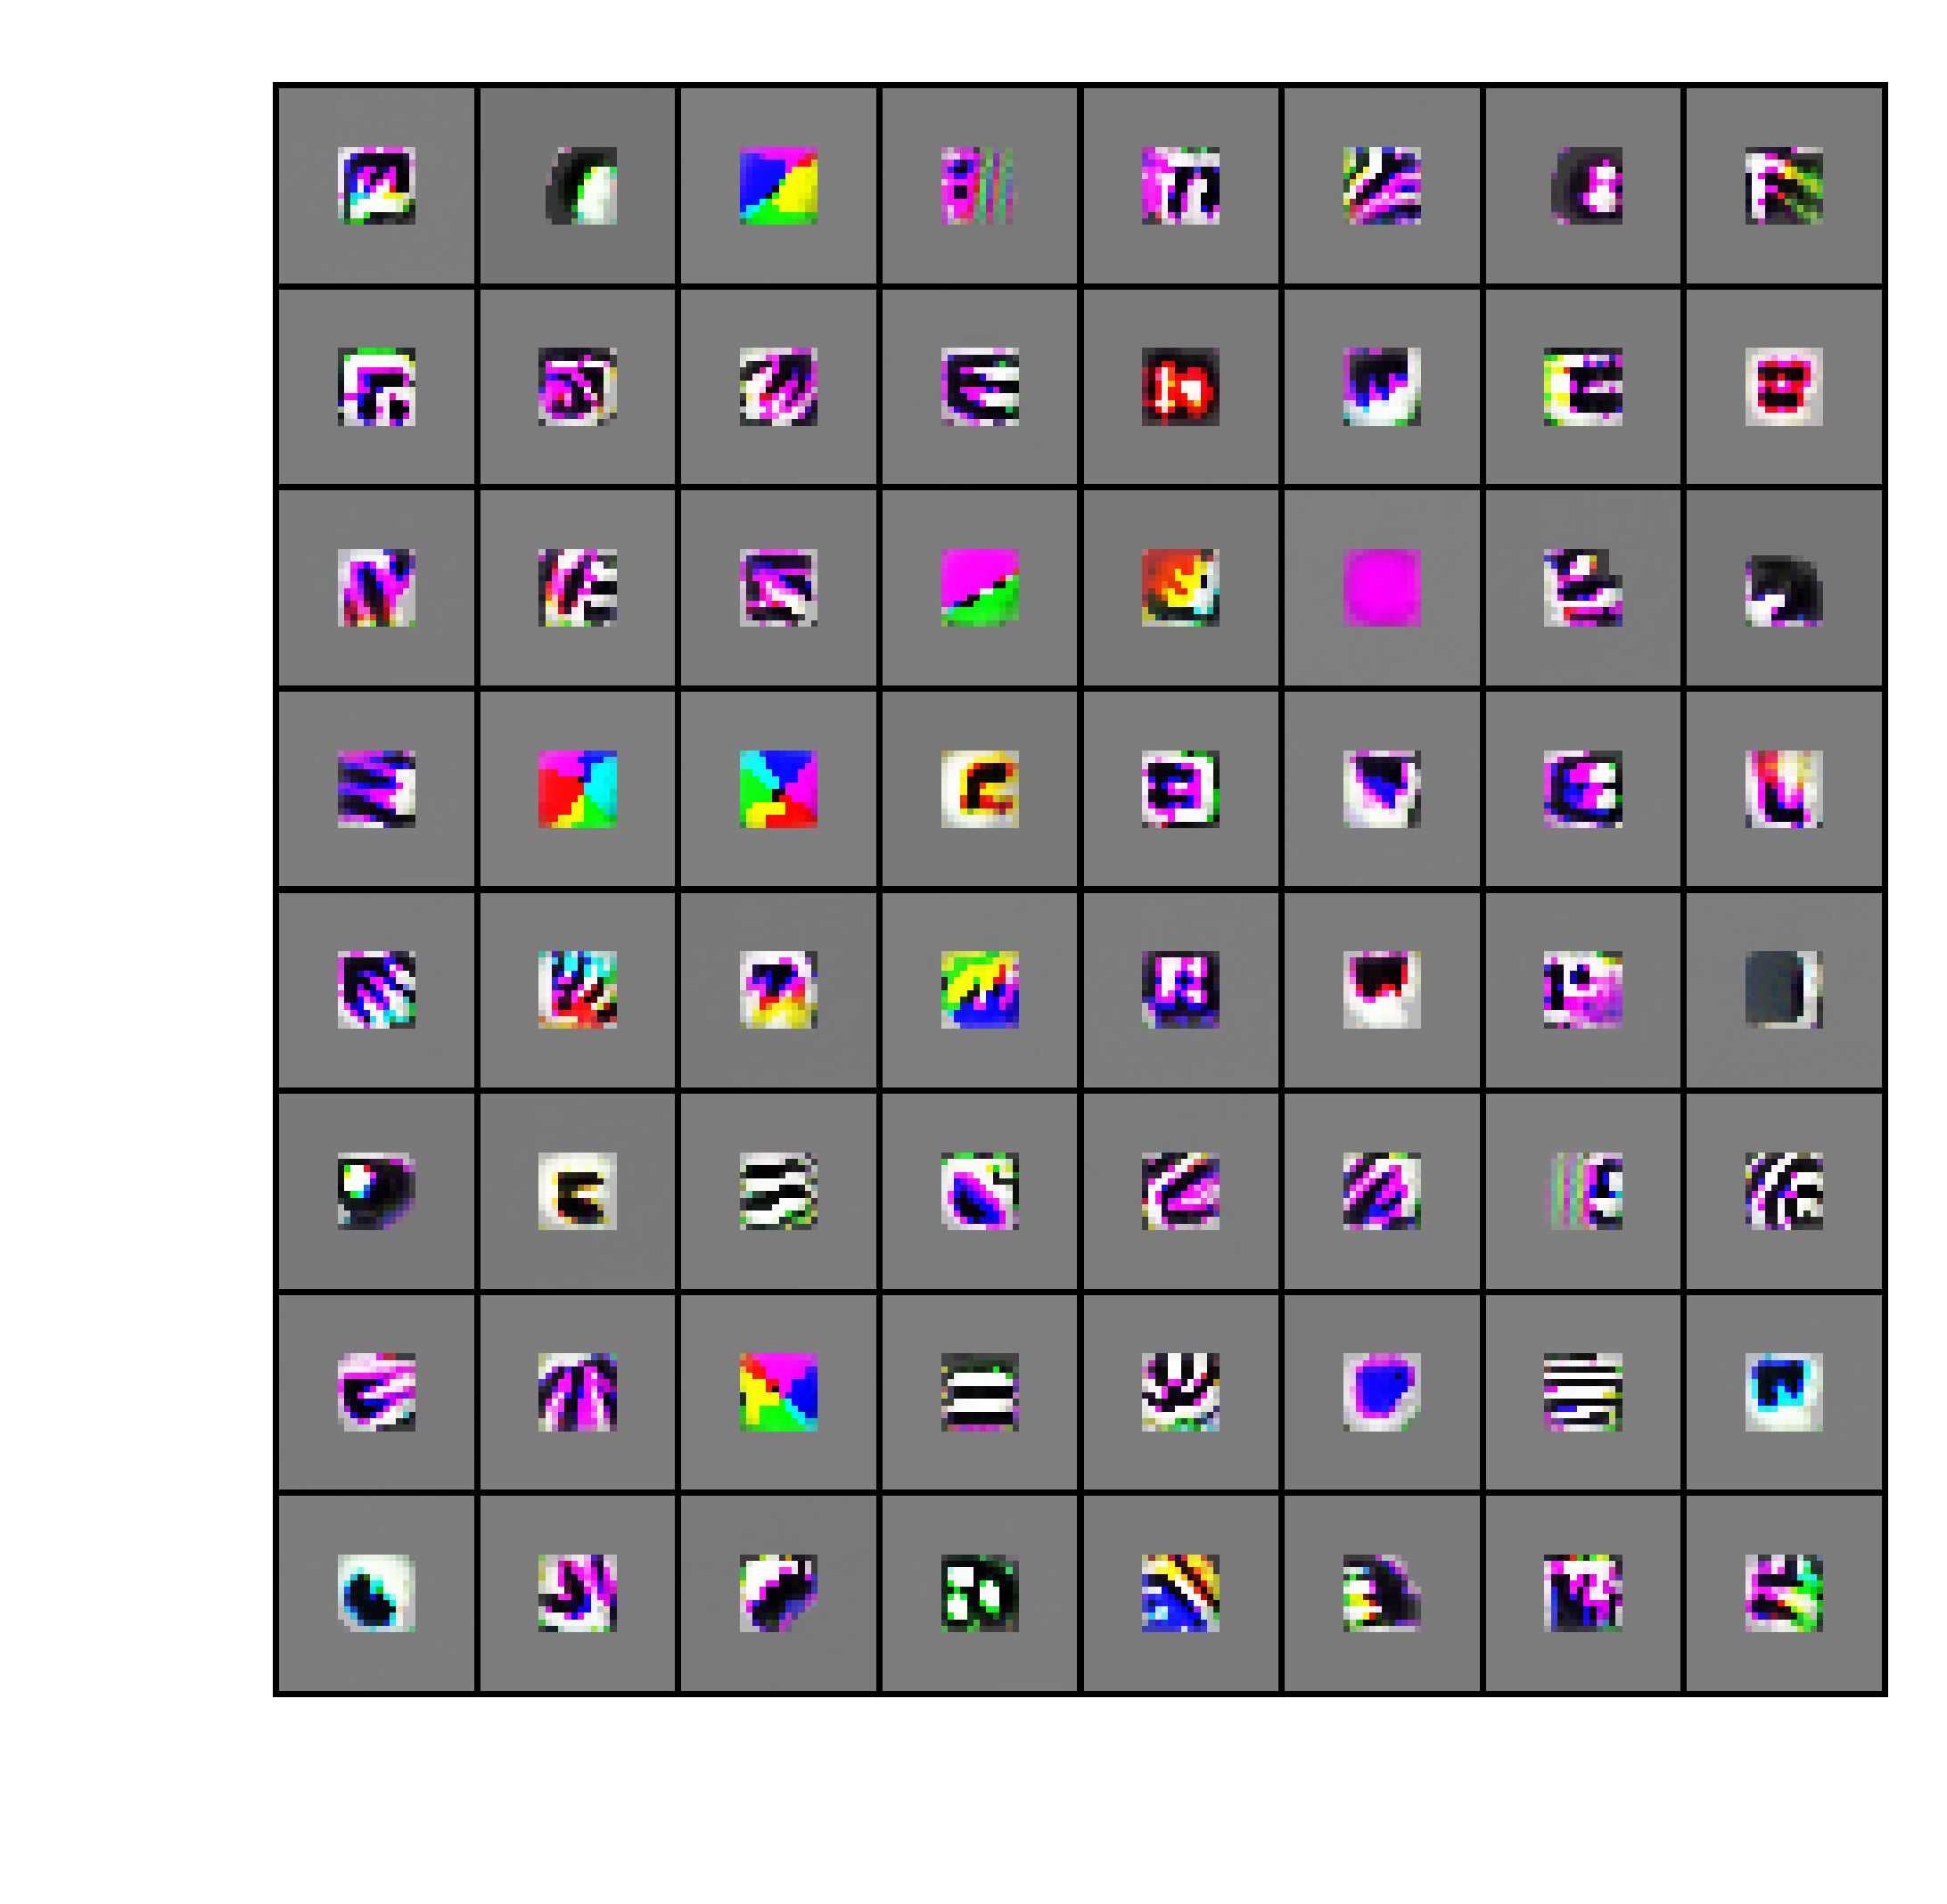

In [91]:
display_map = np.zeros(((height+1)*8 + 1, (width+1)*8 + 1, 3)) # black with one pixel in between each map
for idm,m in enumerate(image_activation_maps['conv2_1_W'][-64:]):
    ycoord = int(idm/8.0)
    xcoord = idm % 8
    display_map[(1+ycoord*(height+1)):((ycoord+1)*(height+1)), (1+(xcoord)*(width+1)):((xcoord+1)*(width+1))] = m #[:,:,[2,1,0]]
    
plt.imshow(display_map)
plt.axis('off')

### Same thing with Conv3_2

# Layer 13

In [92]:
tf.reset_default_graph()
max_depth = 12
# height, width = (100,100)
height, width = (initial_im.shape[1], initial_im.shape[2])
with tf.variable_scope('input'):
    # Given an input tensor of shape `[batch, in_height, in_width, in_channels]`
    X = tf.get_variable("X", dtype=tf.float32, initializer=tf.constant(initial_im))
    X_clipped = tf.clip_by_value(X, -128., 128.)

model = []
prev_output = X_clipped
# filter shape `[filter_height, filter_width, in_channels, out_channels]`
top_layer_reached = 'layer_1'
    
for i,layer in enumerate(weight_keys):
    if (layer[:4] == 'conv') and (layer[-1] == 'W') and (i <= max_depth):
        this_W = weights[layer]
        act_W = tf.nn.conv2d(prev_output, this_W, strides=[1,1,1,1], padding='SAME', use_cudnn_on_gpu=True)
        prev_output = tf.nn.relu(act_W + weights[weight_keys[i+1]])
        model.append(prev_output)
        
        top_layer_reached = layer

num_units = this_W.shape[-1]
my_choices = np.random.choice(range(num_units), size=64, replace=False)
for i in tqdm(my_choices):
    selected_unit = i
    l2_reg = 1e-1
    desirable_activity = -tf.nn.l2_loss(model[-1][0,12:18,12:18,selected_unit])
    undesirable_activity = -l2_reg * tf.nn.l2_loss(X)

    lr = tf.placeholder(tf.float32, shape=[])
    opt = tf.train.AdamOptimizer(learning_rate=lr, beta1=0.99, beta2=0.99, epsilon=1e-08)
    grads = opt.compute_gradients(desirable_activity - undesirable_activity)
    train_op = opt.apply_gradients(grads)
    
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())

    iterations = 1000
    this_lr = 10.

    for it in range(iterations):
        g = sess.run([train_op], feed_dict={lr: this_lr})
        
        if it % 500 == 0:
            this_lr *= 0.1
            
    maximal_image = sess.run(X)
    # rescale to be in [0,1]
    rescaled_img = (maximal_image[0,:,:,:] - np.min(maximal_image[0,:,:,:]))
    rescaled_img /= np.max(rescaled_img)
    image_activation_maps[top_layer_reached].append(rescaled_img)

100%|██████████| 64/64 [06:07<00:00,  6.14s/it]


In [93]:
image_activation_maps.keys()

dict_keys(['conv2_1_W', 'conv3_3_W'])

(-0.5, 248.5, 248.5, -0.5)

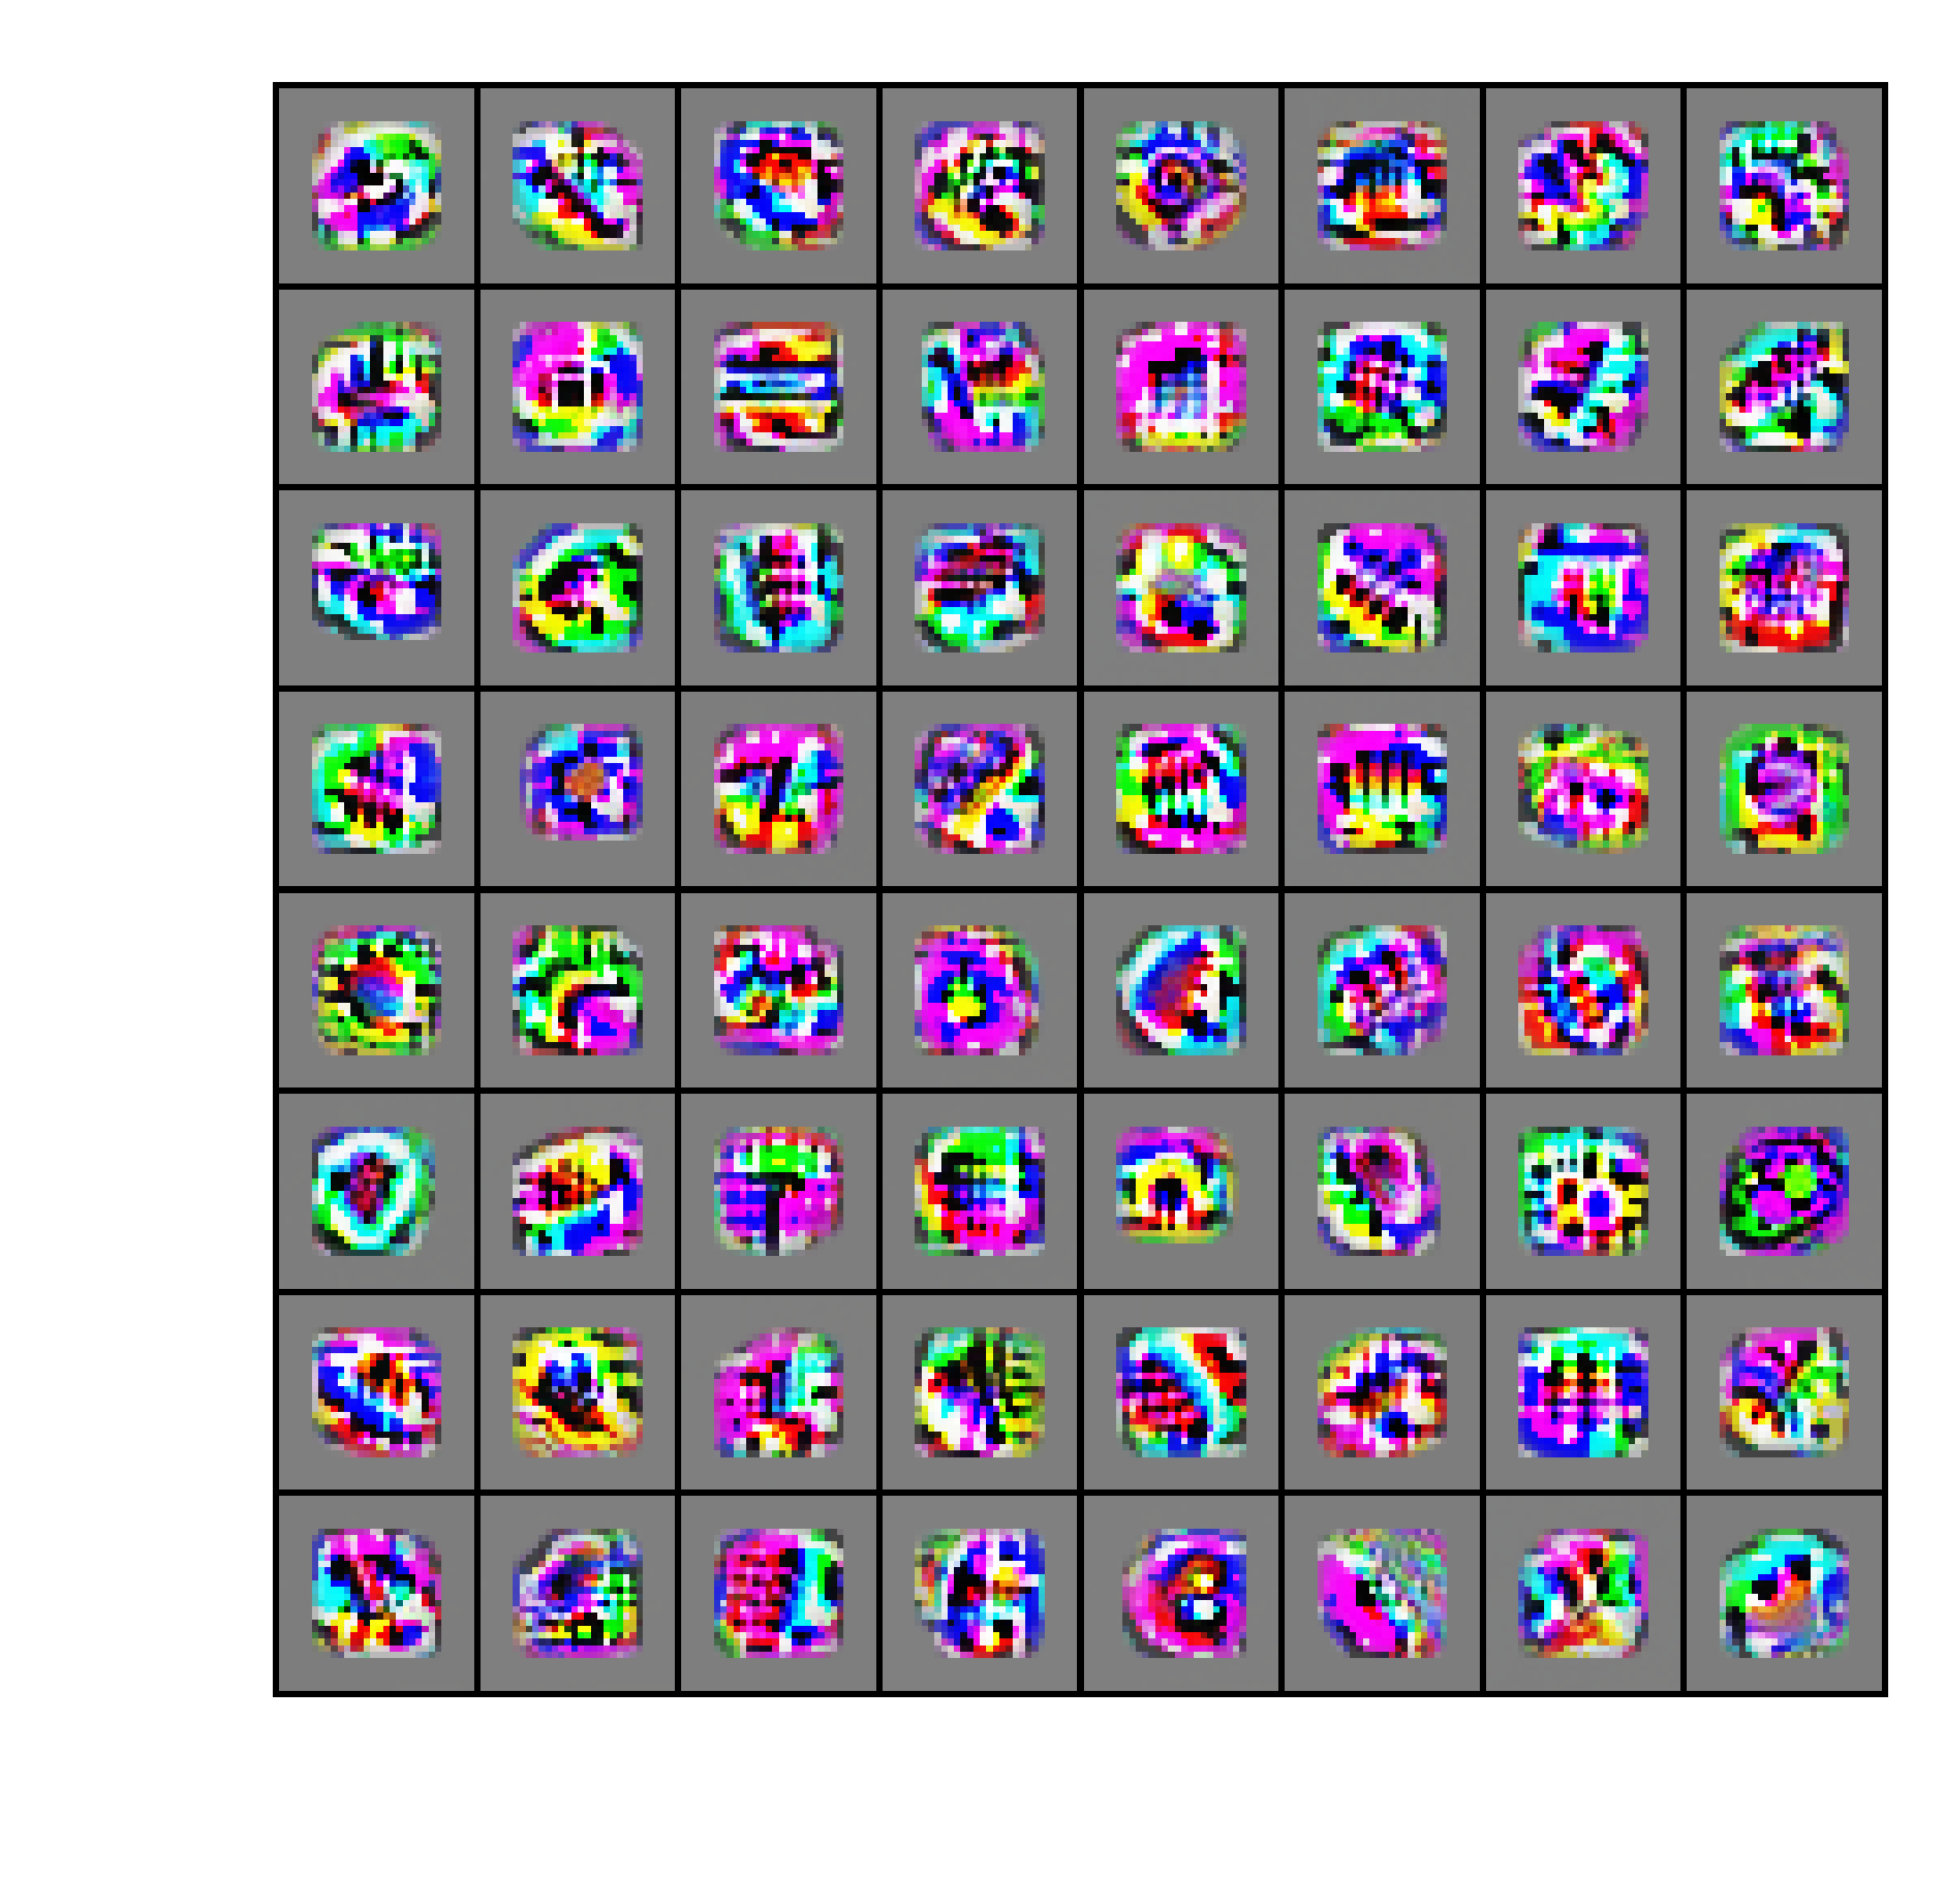

In [94]:
display_map = np.zeros(((height+1)*8 + 1, (width+1)*8 + 1, 3)) # black with one pixel in between each map
for idm,m in enumerate(image_activation_maps['conv3_3_W'][-64:]):
    ycoord = int(idm/8.0)
    xcoord = idm % 8
    display_map[(1+ycoord*(height+1)):((ycoord+1)*(height+1)), (1+(xcoord)*(width+1)):((xcoord+1)*(width+1))] = m #[:,:,[2,1,0]]
    
plt.imshow(display_map)
plt.axis('off')

# Conv5_3

For this one just select a single neuron

In [96]:
tf.reset_default_graph()
max_depth = 25
# height, width = (100,100)
height, width = (initial_im.shape[1], initial_im.shape[2])
with tf.variable_scope('input'):
    # Given an input tensor of shape `[batch, in_height, in_width, in_channels]`
    X = tf.get_variable("X", dtype=tf.float32, initializer=tf.constant(initial_im))
    X_clipped = tf.clip_by_value(X, -128., 128.)

model = []
prev_output = X_clipped
# filter shape `[filter_height, filter_width, in_channels, out_channels]`
top_layer_reached = 'layer_1'
    
for i,layer in enumerate(weight_keys):
    if (layer[:4] == 'conv') and (layer[-1] == 'W') and (i <= max_depth):
        this_W = weights[layer]
        act_W = tf.nn.conv2d(prev_output, this_W, strides=[1,1,1,1], padding='SAME', use_cudnn_on_gpu=True)
        prev_output = tf.nn.relu(act_W + weights[weight_keys[i+1]])
        model.append(prev_output)
        
        top_layer_reached = layer

num_units = this_W.shape[-1]
my_choices = np.random.choice(range(num_units), size=64, replace=False)
for i in tqdm(my_choices):
    selected_unit = i
    l2_reg = 1e-1
    desirable_activity = -tf.nn.l2_loss(model[-1][0,15,15,selected_unit])
    undesirable_activity = -l2_reg * tf.nn.l2_loss(X)

    lr = tf.placeholder(tf.float32, shape=[])
    opt = tf.train.AdamOptimizer(learning_rate=lr, beta1=0.99, beta2=0.99, epsilon=1e-08)
    grads = opt.compute_gradients(desirable_activity - undesirable_activity)
    train_op = opt.apply_gradients(grads)
    
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())

    iterations = 1000
    this_lr = 10.

    for it in range(iterations):
        g = sess.run([train_op], feed_dict={lr: this_lr})
        
        if it % 500 == 0:
            this_lr *= 0.1
            
    maximal_image = sess.run(X)
    # rescale to be in [0,1]
    rescaled_img = (maximal_image[0,:,:,:] - np.min(maximal_image[0,:,:,:]))
    rescaled_img /= np.max(rescaled_img)
    image_activation_maps[top_layer_reached].append(rescaled_img)

100%|██████████| 64/64 [29:53<00:00, 28.61s/it]


In [97]:
image_activation_maps.keys()

dict_keys(['conv5_3_W', 'conv2_1_W', 'conv3_3_W'])

(-0.5, 248.5, 248.5, -0.5)

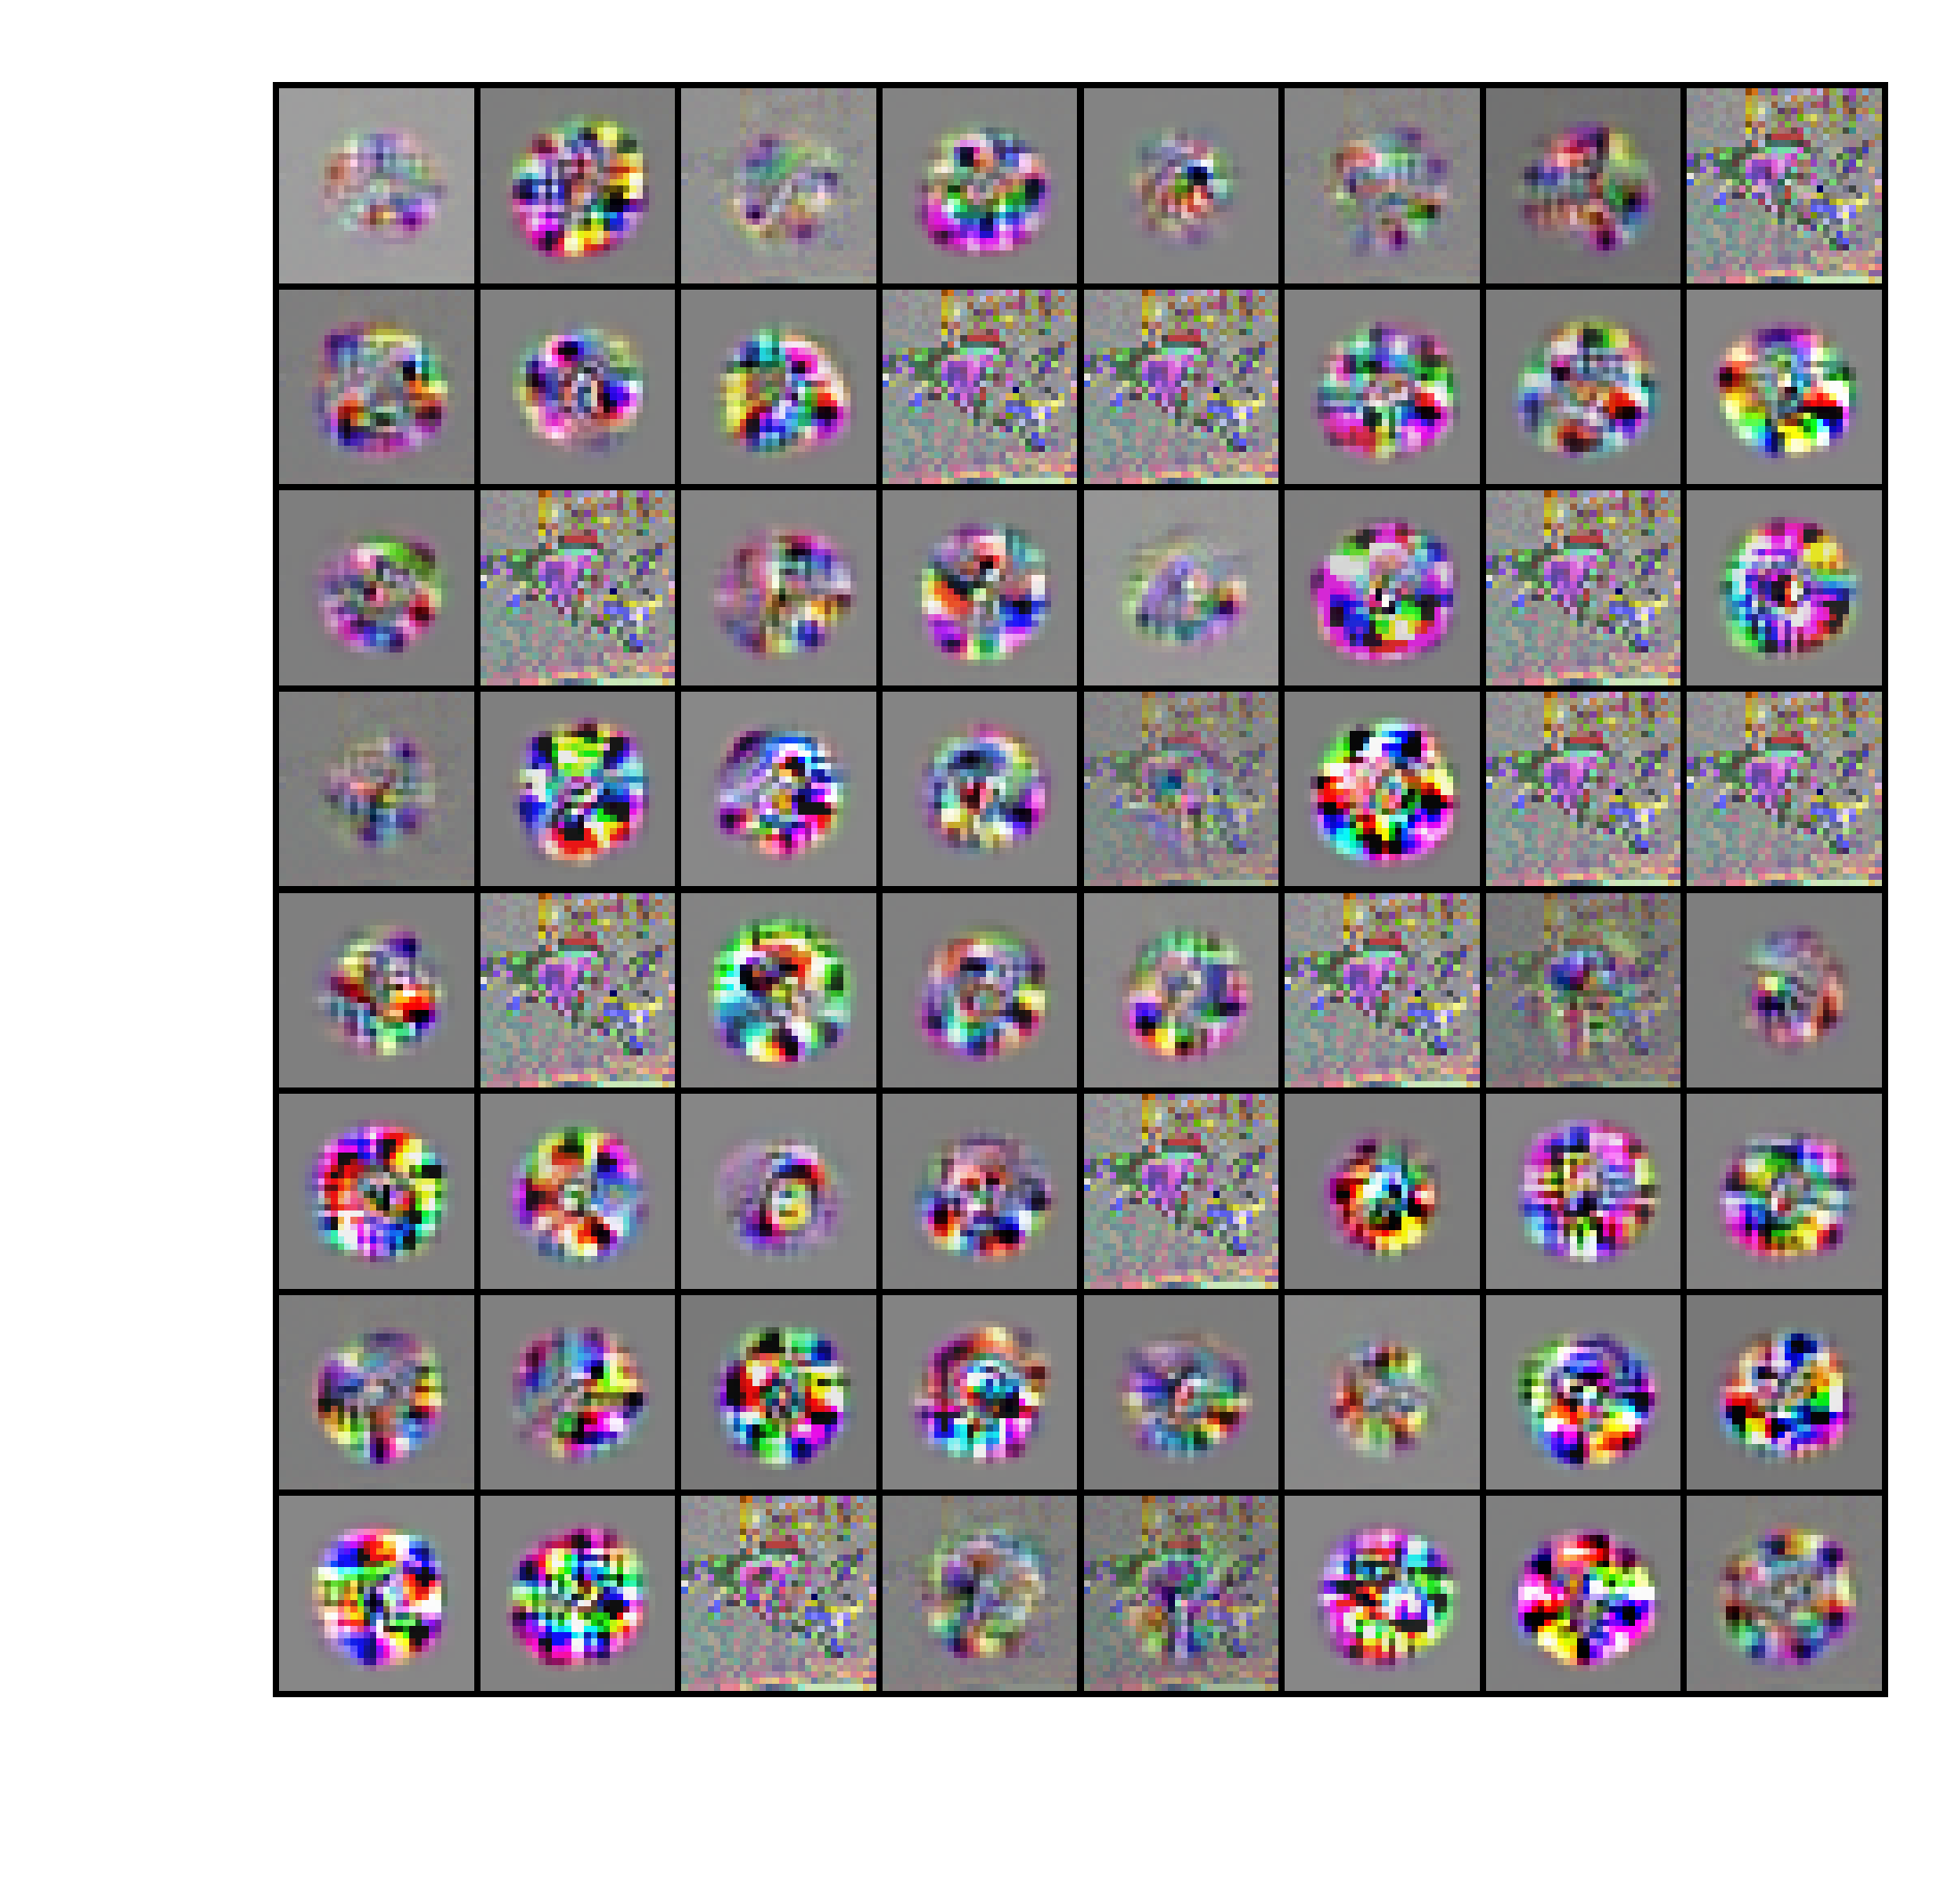

In [98]:
display_map = np.zeros(((height+1)*8 + 1, (width+1)*8 + 1, 3)) # black with one pixel in between each map
for idm,m in enumerate(image_activation_maps['conv5_3_W'][-64:]):
    ycoord = int(idm/8.0)
    xcoord = idm % 8
    display_map[(1+ycoord*(height+1)):((ycoord+1)*(height+1)), (1+(xcoord)*(width+1)):((xcoord+1)*(width+1))] = m #[:,:,[2,1,0]]
    
plt.imshow(display_map)
plt.axis('off')

# Including fully connected layers

In [103]:
for i,l in enumerate(weight_keys):
    print(i, l)

0 conv1_1_W
1 conv1_1_b
2 conv1_2_W
3 conv1_2_b
4 conv2_1_W
5 conv2_1_b
6 conv2_2_W
7 conv2_2_b
8 conv3_1_W
9 conv3_1_b
10 conv3_2_W
11 conv3_2_b
12 conv3_3_W
13 conv3_3_b
14 conv4_1_W
15 conv4_1_b
16 conv4_2_W
17 conv4_2_b
18 conv4_3_W
19 conv4_3_b
20 conv5_1_W
21 conv5_1_b
22 conv5_2_W
23 conv5_2_b
24 conv5_3_W
25 conv5_3_b
26 fc6_W
27 fc6_b
28 fc7_W
29 fc7_b
30 fc8_W
31 fc8_b


In [104]:
weights[weight_keys[28]].shape

(4096, 4096)

In [ ]:
tf.reset_default_graph()
max_depth = 29
height, width = (100,100)
# height, width = (initial_im.shape[1], initial_im.shape[2])
with tf.variable_scope('input'):
    # Given an input tensor of shape `[batch, in_height, in_width, in_channels]`
    # initialize with tf.constant(initial_im)
    X = tf.get_variable("X", dtype=tf.float32, shape=(1,height,width,3), initializer=tf.random_normal_initializer(mean=0., stddev=10.))
    X_clipped = tf.clip_by_value(X, -128., 128.)

model = []
prev_output = X_clipped
# filter shape `[filter_height, filter_width, in_channels, out_channels]`
top_layer_reached = 'layer_1'
    
for i,layer in enumerate(weight_keys):
    if (layer[:4] == 'conv') and (layer[-1] == 'W') and (i <= max_depth):
        this_W = weights[layer]
        act_W = tf.nn.conv2d(prev_output, this_W, strides=[1,1,1,1], padding='SAME', use_cudnn_on_gpu=True)
        prev_output = tf.nn.relu(act_W + weights[weight_keys[i+1]])
        if i in [2, 6, 12, 18, 25]:
            prev_output = tf.nn.pool(prev_output, [2,2], 'MAX', 'SAME', strides=[2,2])
                                     
        model.append(prev_output)
        
        top_layer_reached = layer
                
    
    elif (layer[:2] == 'fc') and (layer[-1] == 'W') and (i <= max_depth):
        if len(this_W.shape) > 2:
            prev_output = tf.reshape(prev_output, (1, -1))
        
        this_W = weights[layer]
        act_W = tf.nn.xw_plus_b(prev_output, this_W, weights[weight_keys[i+1]])
        prev_output = tf.nn.relu(act_W)
        model.append(prev_output)
        
        top_layer_reached = layer

num_units = this_W.shape[-1]
my_choices = np.random.choice(range(num_units), size=64, replace=False)
for i in tqdm(my_choices):
    selected_unit = i
    l2_reg = 1e-1
    if len(model[-1].shape) > 2:
        center=int(model[-1].shape[1]/2.0)
        desirable_activity = -tf.nn.l2_loss(model[-1][0,center,center,selected_unit])
    else:
        desirable_activity = -tf.nn.l2_loss(model[-1][0,selected_unit])
    undesirable_activity = -l2_reg * tf.nn.l2_loss(X)

    lr = tf.placeholder(tf.float32, shape=[])
    opt = tf.train.AdamOptimizer(learning_rate=lr, beta1=0.99, beta2=0.99, epsilon=1e-08)
    grads = opt.compute_gradients(desirable_activity - undesirable_activity)
    train_op = opt.apply_gradients(grads)
    
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())

    iterations = 1000
    this_lr = 10.

    for it in range(iterations):
        g = sess.run([train_op], feed_dict={lr: this_lr})
        
        if it % 500 == 0:
            this_lr *= 0.1
            
    maximal_image = sess.run(X)
    # rescale to be in [0,1]
    rescaled_img = (maximal_image[0,:,:,:] - np.min(maximal_image[0,:,:,:]))
    rescaled_img /= np.max(rescaled_img)
    image_activation_maps[top_layer_reached].append(rescaled_img)

 22%|██▏       | 14/64 [06:00<21:28, 25.78s/it]

In [ ]:
center

In [ ]:
image_activation_maps.keys()

In [107]:
? tf.nn.pool